# Lecture 3: Automatic Differentiation

As we have seen, neural networks are optimized using GD techniques, which involve a lot of differentiation. For small models, we could try to derive the gradients manually, but in general it is impossible to do so. Thus, we need a way to automatically find these gradients, hence automatic differentiation (AD). In this lecture, we will understand how AD works, and we will see some practical applications of this.

### 3.1 Introduction to Automatic Differentiation

In [ ]:
import torch

#torch.autograd is PyTorch's AD engine that helps in NN training

In [4]:
# Example 1: AD of a basic function

x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([1.0], requires_grad=True)
z = torch.tensor([1.0], requires_grad=True)
# Define a function that takes two variables as input and returns their sum
def f(x, y, z):
    return torch.log(torch.sin(x) + torch.tanh(y**2))/z

# Compute the gradient of f with respect to x and y
g = f(x, y, z)
g.backward()

# The gradients of f with respect to x and y are stored in x.grad and y.grad
print(x.grad)   
print(y.grad)   
print(z.grad)

tensor([0.3370])
tensor([0.5240])
tensor([-0.4719])


C:\Users\pablo\AppData\Local\Temp\ipykernel_4868\1347656166.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 0.5*x**(2.0) + kappa*np.exp(-(x)**2/2)


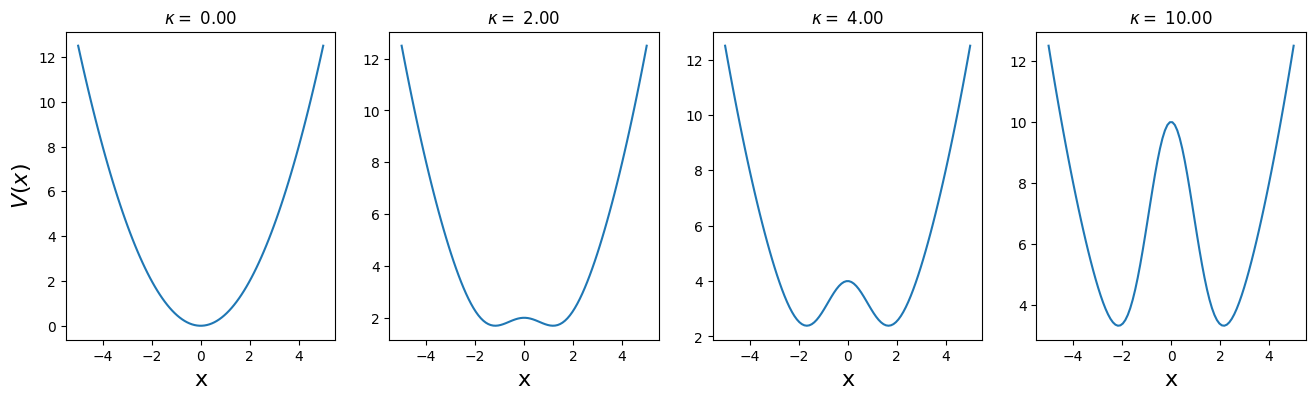

In [5]:
#Example 2: Quantum Harmonic Oscillator + Double-well potential

import matplotlib.pyplot as plt
import numpy as np
from torch.linalg import eigh

#Define a system of size L=10, N_x discretization points, a function returning ext potential and a function returning
#matrix representation of the Hamiltonian

L = 10
Nx = 100
x = torch.linspace(-L/2,L/2,Nx)
dx = x[1] - x[0]

def get_potential(x,kappa):
    return 0.5*x**(2.0) + kappa*np.exp(-(x)**2/2)

def get_H(kappa):
    H_T = torch.zeros((Nx,Nx))
    ones = torch.ones(Nx)
    H_T = -0.5/dx**2*(torch.diag_embed(ones[:-1],offset=1)-2*torch.diag_embed(ones,offset=0)+torch.diag_embed(ones[:-1],offset=-1))
    H_V = torch.diag(get_potential(x,kappa))
    H = H_T + H_V
    return H

kappa_vec = torch.tensor([0,2,4,10])
N_kappa = kappa_vec.size(0)

fig,ax = plt.subplots(1,N_kappa,figsize=(16,4))
FontSize=16
for kappa_i in range(0,N_kappa):
    kappa = kappa_vec[kappa_i]
    V = get_potential(x,kappa)
    ax[kappa_i].plot(x,V.detach().numpy())
    ax[kappa_i].set_title(r"$\kappa = $ " + "{:2.2f}".format(kappa.item()))
    ax[kappa_i].set_xlabel("x",fontsize=FontSize)
ax[0].set_ylabel(r"$V(x)$",fontsize=FontSize)
plt.show()


Pytorch function torch.eigh calculates eigenfunctions and eigenvalues of a given matrix: this allows us to write two functions returning ground state energy  $E_{GS}$ , and ground state gap  $\Delta E$ , i.e. energy difference between two first eigenenergies.

C:\Users\pablo\AppData\Local\Temp\ipykernel_4868\1347656166.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 0.5*x**(2.0) + kappa*np.exp(-(x)**2/2)
C:\Users\pablo\AppData\Local\Temp\ipykernel_4868\539439291.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ax[2,kappa_i].set_yticks(np.arange(0,E_max,0.5))


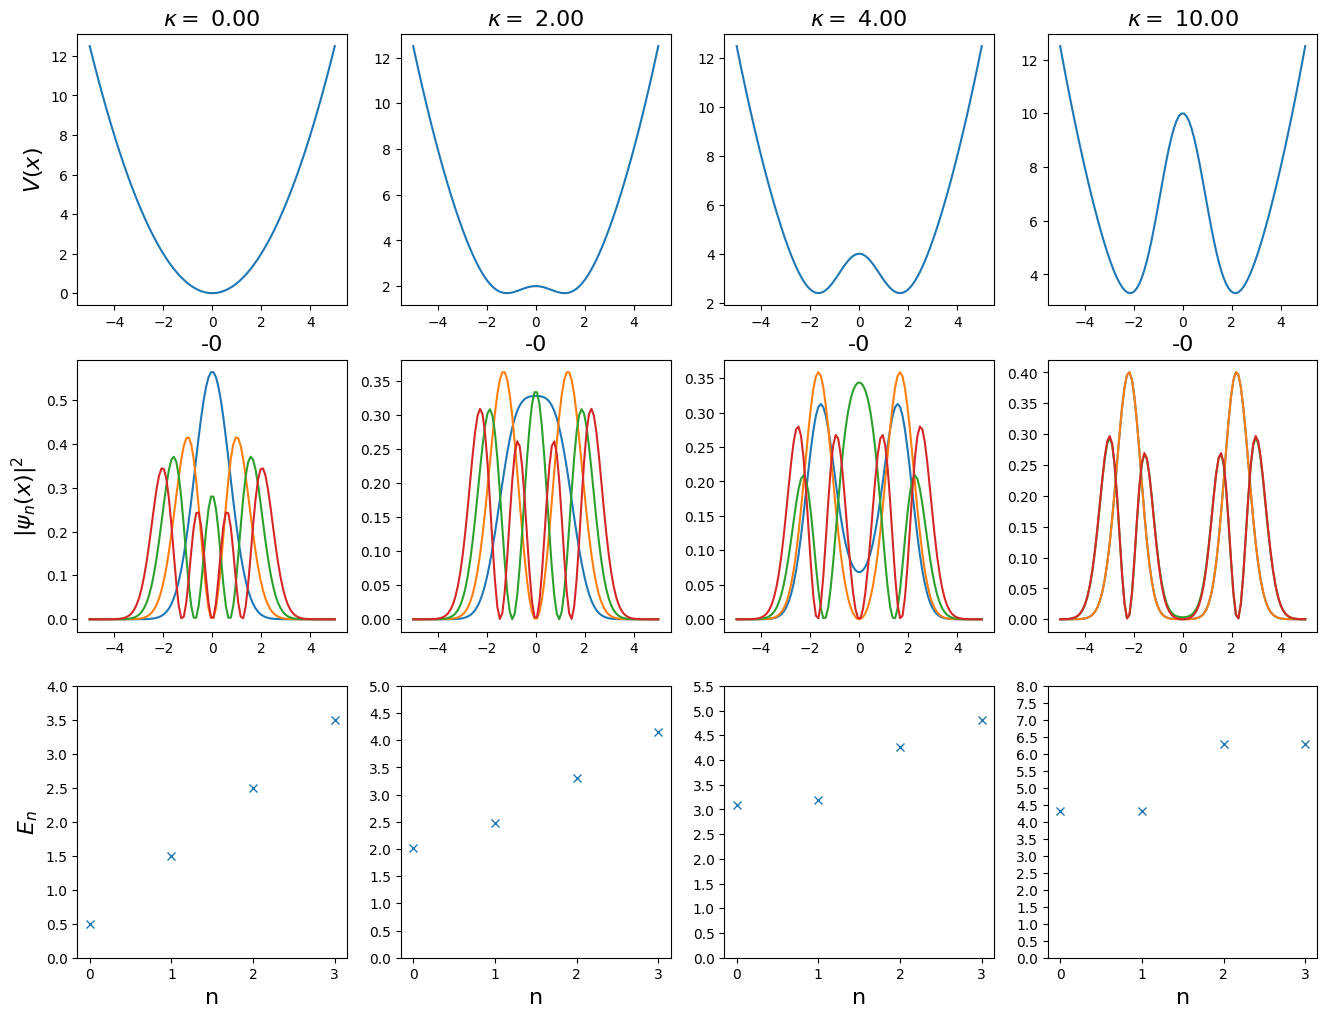

In [6]:
def get_energy_ground_state(kappa):
    H = get_H(kappa)
    Energies, Vectors = eigh(H)
    E_GS = Energies[0]    
    return E_GS

def get_gap(kappa):
    H = get_H(kappa)
    Energies, Vectors = eigh(H)
    gap = Energies[1] - Energies[0]    
    return gap

fig, ax = plt.subplots(3, N_kappa, figsize=(16,12))
FontSize = 16
for kappa_i in range(0, N_kappa):
    kappa = kappa_vec[kappa_i]
    V = get_potential(x,kappa)
    ax[0,kappa_i].plot(x,V.detach().numpy())
    ax[0,kappa_i].set_title(r"$\kappa = $ " + "{:2.2f}".format(kappa.item()),fontsize=FontSize)
    ax[0,kappa_i].set_xlabel("x",fontsize=FontSize)

    H = get_H(kappa)
    Energies, Vectors = eigh(H)
    rho = torch.abs(Vectors)**2/dx
    n_max =  4            # maximal number of eigenstates
    E_max = Energies[n_max] #
 
    for i in range(0,n_max):
        ax[1,kappa_i].plot(x,rho[:,i].detach().numpy())
    ax[2,kappa_i].plot(Energies[0:n_max].detach().numpy(),'x')
   
    ax[0,kappa_i].set_xlabel("-0",fontsize=FontSize)

    ax[2,kappa_i].set_xlabel(r"n",fontsize=FontSize)
    ax[2,kappa_i].set_yticks(np.arange(0,E_max,0.5))
    
    
ax[0,0].set_ylabel(r"$V(x)$",fontsize=FontSize) 
ax[1,0].set_ylabel(r"$|\psi_n(x)|^2$",fontsize=FontSize) 
ax[2,0].set_ylabel(r"$E_n$",fontsize=FontSize) 
plt.show()

Let us check how GS energies change with $\kappa$:

C:\Users\pablo\AppData\Local\Temp\ipykernel_4868\1347656166.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 0.5*x**(2.0) + kappa*np.exp(-(x)**2/2)


Text(0, 0.5, 'energy gap $\\Delta{E}$')

<Figure size 640x480 with 0 Axes>

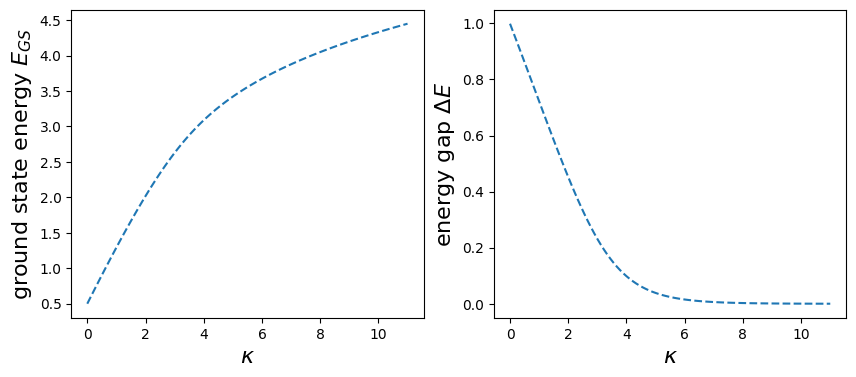

In [7]:
fig = plt.figure()
E_gs_vs_kappa = []
gap_vs_kappa = []
kappa_max = 11
kappa_vec = np.linspace(0,kappa_max,100)
for kappa in kappa_vec:
    E_gs_vs_kappa.append([get_energy_ground_state(kappa)])
    gap_vs_kappa.append([get_gap(kappa)])
    
FontSize = 16
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(kappa_vec, E_gs_vs_kappa, '--')
ax[1].plot(kappa_vec, gap_vs_kappa, '--')
ax[0].set_xlabel(r"$\kappa$",fontsize=FontSize)
ax[0].set_ylabel(r"ground state energy $E_{GS}$",fontsize=FontSize)
ax[1].set_xlabel(r"$\kappa$",fontsize=FontSize)
ax[1].set_ylabel(r"energy gap $\Delta{E}$", fontsize=FontSize)

Finally, we will compute $\frac{dE_{gs}}{d\kappa}$ at a given $\kappa$ using torch.autograd:

C:\Users\pablo\AppData\Local\Temp\ipykernel_4868\1347656166.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 0.5*x**(2.0) + kappa*np.exp(-(x)**2/2)


tensor(0.1249)


Text(0, 0.5, '$\\frac{d\\Delta E}{d\\kappa}$')

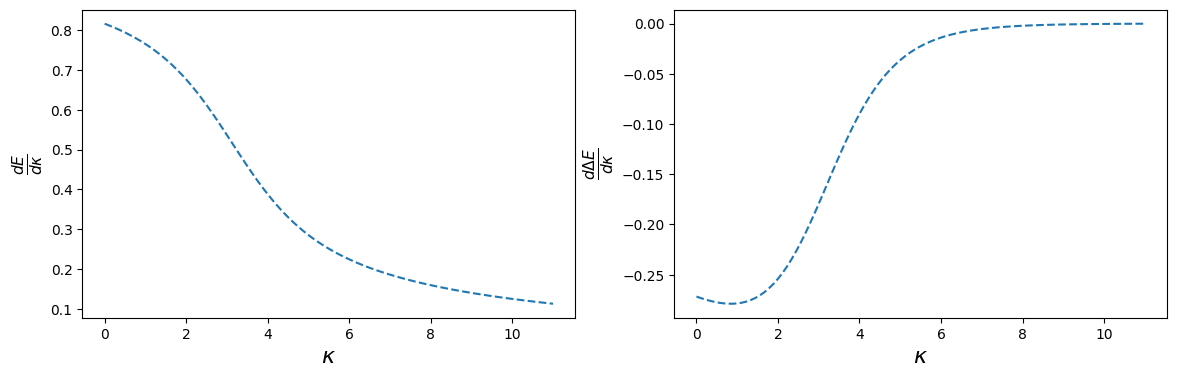

In [8]:
kappa_fixed = torch.tensor(10., requires_grad = True)
E_GS = get_energy_ground_state(kappa_fixed)
E_GS.backward()
print(kappa_fixed.grad)

dEdkappa = []
dgapdkappa = []
for kappa in kappa_vec:
    kappa_fixed_1 = torch.tensor(kappa, requires_grad = True)
    E_GS = get_energy_ground_state(kappa_fixed_1)
    E_GS.backward()
    diff = kappa_fixed_1.grad
    dEdkappa.append([diff.item()])
    
    kappa_fixed_2 = torch.tensor(kappa, requires_grad = True)    
    gap = get_gap(kappa_fixed_2)
    gap.backward()
    diff = kappa_fixed_2.grad
    dgapdkappa.append([diff.item()])    

fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(kappa_vec,dEdkappa,'--')
ax[1].plot(kappa_vec,dgapdkappa,'--')
FontSize=16
ax[0].set_xlabel(r"$\kappa$",fontsize=FontSize)
ax[0].set_ylabel(r"$\frac{dE}{d\kappa}$",fontsize=FontSize)

ax[1].set_xlabel(r"$\kappa$",fontsize=FontSize)
ax[1].set_ylabel(r"$\frac{d\Delta E}{d\kappa}$",fontsize=FontSize)

### 3.2 Inverse Schrödinger problem

Typically, the Schrödinger problem consists on finding the eigenstates for a given known Hamiltonian. In this second application, we will try to find the original Hamiltonian from a known ground state.

In [9]:
import torch as pt

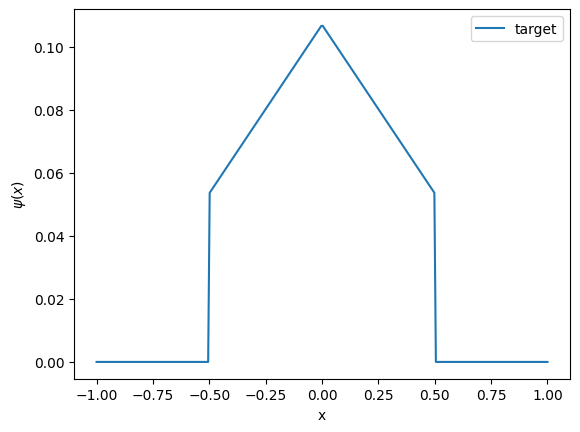

In [10]:
# Set up the 1D axis and target density
xmin, xmax, N = -1.0, 1.0, 300
xmesh = torch.linspace(xmin, xmax, N, requires_grad=False)
target = np.zeros(N)
idx = (np.abs(xmesh.numpy()) < 0.5)
target[idx] = 1.0 - np.abs(xmesh.numpy()[idx])
target /= np.linalg.norm(target)
target = torch.tensor(target, dtype=torch.float64)

plt.plot(xmesh.numpy(), target.numpy(), label="target")
plt.xlabel("x")
plt.ylabel("$ψ(x)$")
plt.legend()
plt.show()

# Define kinetic energy term using finite differences
h = (xmax - xmin) / N
dx = h
K = -0.5 / h**2 * (
    torch.diag(-2 * torch.ones(N, dtype=torch.float64))
    + torch.diag(torch.ones(N - 1, dtype=torch.float64), diagonal=1)
    + torch.diag(torch.ones(N - 1, dtype=torch.float64), diagonal=-1)
)

def make_loss(K, target):
    def loss_fn(potential):
        H = K + torch.diag(potential)
        eigvals, eigvecs = torch.linalg.eigh(H)
        psi0 = eigvecs[:, 0]
        loss = torch.sum((psi0**2 - target**2)**2)
        return loss

    return loss_fn

In [13]:
def make_loss(K, target):
    def loss_fn(potential):
        H = K + torch.diag(potential)
        eigvals, eigvecs = torch.linalg.eigh(H)
        psi0 = eigvecs[:, 0]
        loss = torch.sum((psi0**2 - target**2)**2)
        return loss

    return loss_fn

# Define kinetic energy term using finite differences
K = -0.5 / dx**2 * (
    torch.diag(-2 * torch.ones(N, dtype=torch.float64))
    + torch.diag(torch.ones(N - 1, dtype=torch.float64), diagonal=1)
    + torch.diag(torch.ones(N - 1, dtype=torch.float64), diagonal=-1)
)

#Request that the state is the ground state of H

# Initialize potential and loss function
init_potential = 0.5 * xmesh**2
init_potential = init_potential.clone().detach().requires_grad_(True)

# Define loss function and optimizer
loss_fn = make_loss(K, target)
optimizer = torch.optim.Adam([init_potential], lr=0.01)

# Automatic differentiation loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_fn(init_potential)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}, Loss: {loss.item()}")



Epoch 0, Loss: 0.0009149618499503843
Epoch 100, Loss: 0.0004908089287839033
Epoch 200, Loss: 0.0002962755403878319
Epoch 300, Loss: 0.00021291728209286778
Epoch 400, Loss: 0.0001782339612699558
Epoch 500, Loss: 0.00016289643981518099
Epoch 600, Loss: 0.00015458904676589422
Epoch 700, Loss: 0.00014881905180476665
Epoch 800, Loss: 0.00014410401995153515
Epoch 900, Loss: 0.00013994339819433461
Epoch 1000, Loss: 0.00013613268486882012
Epoch 1100, Loss: 0.00013256259325695308
Epoch 1200, Loss: 0.00012916399147492886
Epoch 1300, Loss: 0.000125891527876726
Epoch 1400, Loss: 0.0001227167069551453
Epoch 1500, Loss: 0.00011962336735671996
Epoch 1600, Loss: 0.00011660415542762858
Epoch 1700, Loss: 0.00011365774086189576
Epoch 1800, Loss: 0.00011078660230112917
Epoch 1900, Loss: 0.00010799535928132856
Epoch 2000, Loss: 0.00010528957266200564
Epoch 2100, Loss: 0.00010267485447772982
Epoch 2200, Loss: 0.00010015630386627289
Epoch 2300, Loss: 9.773811946575968e-05
Epoch 2400, Loss: 9.542337843052145e

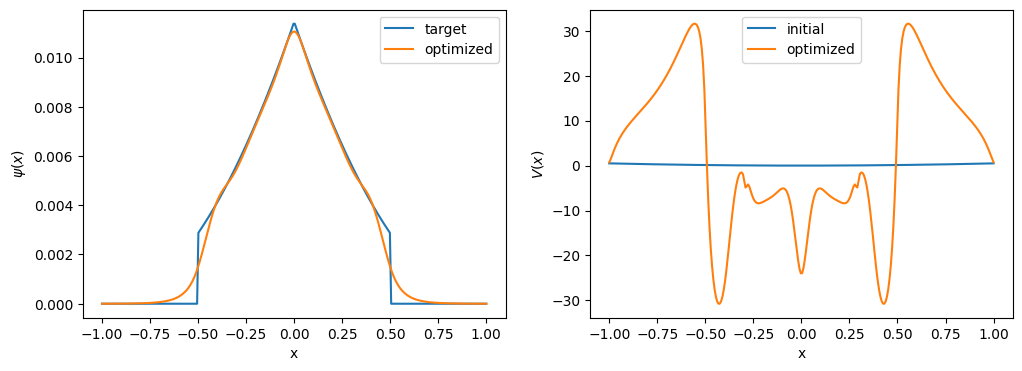

In [14]:
# Plot results
fig, (ax_psi, ax_potential) = plt.subplots(1, 2, figsize=(12, 4))

# Ground state wave function
H = K + torch.diag(init_potential.detach())
eigvals, eigvecs = torch.linalg.eigh(H)
psi0 = eigvecs[:, 0]

ax_psi.plot(xmesh.numpy(), np.abs(target.numpy())**2, label="target")
ax_psi.plot(xmesh.numpy(), np.abs(psi0.detach().numpy())**2, label="optimized")
ax_psi.set_xlabel("x")
ax_psi.set_ylabel("$ψ(x)$")
ax_psi.legend()

# Potential
ax_potential.plot(xmesh.numpy(), (0.5 * xmesh**2).numpy(), label="initial")
ax_potential.plot(xmesh.numpy(), init_potential.detach().numpy(), label="optimized")
ax_potential.set_xlabel("x")
ax_potential.set_ylabel("$V(x)$")
ax_potential.legend()

plt.show()

### 3.3 Variational Quantum Eigensolver (VQE)

Finding a ground state energy of a quantum many-body system is one of the main objectives of Quantum Physics. However, typical diagonalization methods fail due to the expontential increase of the Hilbert space with the number of particles. The VQE is a variational method used for finding GS on quantum computers with the help of AD. We will implement a simple VQE for a system containing $L=4$ spins-1/2 from scratch. The Hamiltonian is:
$$
H = \sum_i \sum_{\tau=x,y,z} J_{\tau} \sigma_i^\tau \sigma_{i+1}^\tau + \sum_i\sum_{\tau = x,y,z} h^\tau \sigma_i^\tau
$$
where $J_\tau$ and $h_\tau$ are the parameters of the Hamiltonian.

In [15]:
from torch import matrix_exp as expm
from tqdm import tqdm

In [16]:
#Define some Quantum Gates

def get_Identity(k):  # returns k-tensor product of the identity operator, ie. Id^k
    Id = id_local
    for i in range(0, k-1):
        Id = pt.kron(Id, id_local)
    return Id
    
def get_chain_operator(A, L, i):
    Op = A
    if(i == 1):
        Op = pt.kron(A,get_Identity(L-1))
        return Op
    if(i == L):
        Op = pt.kron(get_Identity(L-1),A)
        return Op
    if(i>0 and i<L):
        Op = pt.kron(get_Identity(i-1), pt.kron(Op, get_Identity(L-i)))
        return Op

def get_chain_operators(L):
    
    Id = get_chain_operator(id_local, L, 1)
    X = {}
    Y = {}
    Z = {}

    for qubit_i in range(1, L+1):    # Loop over indices on a 2-dimensional grid (i_x,i_y)
        X[qubit_i] = get_chain_operator(sigma_x, L, qubit_i)        # Define operator X_i acting on spin (i_x,i_y)
        Y[qubit_i] = get_chain_operator(sigma_y, L, qubit_i)        # Define operator Y_i acting on spin (i_x,i_y)
        Z[qubit_i] = get_chain_operator(sigma_z, L, qubit_i)        # Define operator Z_i acting on spin (i_x,i_y)
    return Id, X, Y, Z


id_local = pt.tensor([[1.,0],[0,1.]])
sigma_x = pt.tensor([[0,1.],[1.,0]])
sigma_y = 1j*pt.tensor([[0,-1.],[1.,0]])
sigma_z = pt.tensor([[1.,0],[0,-1.]])
hadamard = 1.0/pt.sqrt(pt.tensor(2))*pt.tensor([[1,1],[1,-1]])+1j*0    


def Rx(theta, j):
    return expm(-1j*theta/2*X[j])

def Ry(theta, j):
    return expm(-1j*theta/2*Y[j])

def Rz(theta, j):
    return expm(-1j*theta/2*Z[j])    

def CNOT(i,j):
    return  expm(pt.pi/4*(Id - Z[i])@(Id - X[j])*1j) 


In [17]:
L = 6       # Number of qubits
D = 2**L    # Size of the Hilbert space
# Pauli operators
Id, X, Y, Z = get_chain_operators(L)

# Hamiltonian parameters
J = {"x": 1.,
     "y": 1.,
     "z": -1.}
h = {"x": 1.,
     "y": 1.5,
     "z": 3.}

H = pt.zeros((D,D))
for i in range(1,L):
    H = H + J["x"]*X[i]@X[i+1] + J["y"]*Y[i]@Y[i+1] + J["z"]*Z[i]@Z[i+1]
for i in range(1,L+1):
    H = H + h["x"]*X[i] + h["y"]*Y[i] + h["z"]*Z[i]
    
    
E, P = eigh(H)
E_GS = E[0]
print('Exact ground state energy E_{GS} = ' + "{:2.2f}".format(E_GS))



Exact ground state energy E_{GS} = -24.58


In [19]:
#Define our ansatz for the GS
def psi_ansatz(theta):   
    psi_re = pt.zeros(D)
    psi_im = pt.zeros(D)
    
    psi_re[D-1] = 1   # In computational basis this vector 
                      # corresponds to all spins down
    
    psi_tmp = pt.complex(psi_re,psi_im)    
    
    psi_tmp = Ry(theta[0],1)@psi_tmp
    psi_tmp = Ry(theta[1],2)@psi_tmp
    psi_tmp = Ry(theta[2],3)@psi_tmp
    psi_tmp = Ry(theta[3],4)@psi_tmp
 
    
    psi_tmp = Rz(theta[4],1)@psi_tmp
    psi_tmp = Rz(theta[5],2)@psi_tmp
    psi_tmp = Rz(theta[6],3)@psi_tmp
    psi_tmp = Rz(theta[7],4)@psi_tmp    
  
    

    psi_tmp = CNOT(1,2)@psi_tmp
    psi_tmp = CNOT(2,3)@psi_tmp
    psi_tmp = CNOT(3,4)@psi_tmp
    

    psi_tmp = Rz(theta[8],1)@psi_tmp
    psi_tmp = Rz(theta[9],2)@psi_tmp
    psi_tmp = Rz(theta[10],3)@psi_tmp
    psi_tmp = Rz(theta[11],4)@psi_tmp       
   
    
    psi_tmp = Ry(theta[12],1)@psi_tmp
    psi_tmp = Ry(theta[13],2)@psi_tmp
    psi_tmp = Ry(theta[14],3)@psi_tmp
    psi_tmp = Ry(theta[15],4)@psi_tmp
    
    psi_tmp = CNOT(1,2)@psi_tmp
    psi_tmp = CNOT(2,3)@psi_tmp
    psi_tmp = CNOT(3,4)@psi_tmp

    
    return psi_tmp

100%|██████████| 400/400 [00:45<00:00,  8.74it/s]


Text(0, 0.5, 'Energy')

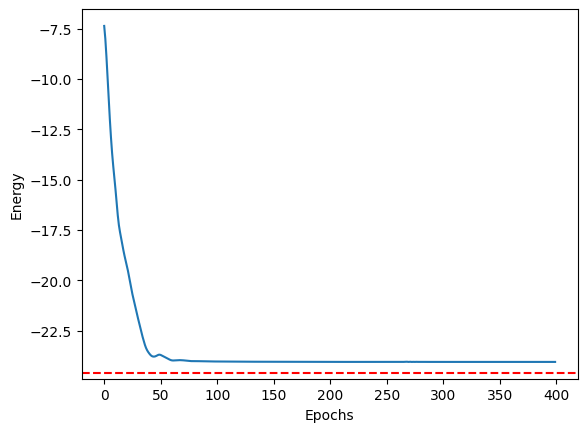

In [20]:
def get_E(theta):
    psi_tmp = psi_ansatz(theta)
    E = pt.vdot(psi_tmp, H@psi_tmp)
    return E.real

theta = pt.zeros(16,requires_grad=True)
optimizer = pt.optim.Adam([theta],lr = 0.1)
E_variational_vs_epochs = []
for i in tqdm(range(0,400)):
    loss = get_E(theta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    E_variational_vs_epochs.append(get_E(theta).item().real)

plt.plot(E_variational_vs_epochs)
plt.axhline(y = E_GS, color = 'r', linestyle = '--')
plt.xlabel("Epochs")
plt.ylabel("Energy")